In [18]:
import matplotlib 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


## NGRIP results

In [19]:
E_data =  6.576929675080343
delta_E_data =  2.997816266913335
P_data =  0.44927676498507496
delta_P_data =  0.2297324573307872

int_len_mean_data =  1545.3235294117646
delta_int_len_mean_data =  265.0207988815458

int_len_spread_data =  1728.9087806472924
delta_int_len_spread_data =  212.81395957713534

stad_len_mean_data =  1958.7941176470588
delta_stad_len_mean_data =  335.93041976193956

stad_len_spread_data =  3437.3925461657686
delta_stad_len_spread_data =  423.1137735887893

Ngrip_vec_mu = np.array([E_data, P_data, 
        int_len_mean_data, int_len_spread_data,
        stad_len_mean_data, stad_len_spread_data])

Ngrip_vec_delta = np.array([delta_E_data, delta_P_data,
        delta_int_len_mean_data, delta_int_len_spread_data,
        delta_stad_len_mean_data, delta_stad_len_spread_data])

## No Slope Grid

### Load the datasets

For the no slope the runs where in 2d grid with 6 files one for each node run. 
Spaning in sigma from 0 to 0.3 and in gamma from 0.6 to 1.5 with 20 experiements
for each. 


    gamma       0.6              0.9              1.2              1.5 
    sigma  0     |----------------|----------------|----------------|
                 |                |                |                |
                 |     file 1     |     file 2     |     file 3     |	
                 |                |                |                |
    sigma  0.15  |----------------|----------------|----------------|
                 |                |                |                |
                 |     file 4     |     file 5     |     file 6     |	
                 |                |                |                |
    sigma  0.3   |----------------|----------------|----------------|

The files are collected to one large dataset. All runs was with a resolution of
30 steps in $\gamma$, and 15 steps in $\sigma$, with the number of experiments $N_{exp}$ as 20.

In [20]:
no_slope_grid = []

for i in range(1, 7):
    no_slope_grid.append(xr.open_dataset(f'Data/Loh_polynode_2_2_2_file_{i}.nc'))

# combine the first three and the next three along the gamma axis

no_slope_grid[0].drop_sel(gamma = no_slope_grid[0].gamma[-1])
no_slope_grid[0].drop_sel(sigma = no_slope_grid[0].sigma[-1])

no_slope_grid[1].drop_sel(gamma = no_slope_grid[1].gamma[-1])
no_slope_grid[1].drop_sel(sigma = no_slope_grid[1].sigma[-1])

#no_slope_grid[2].drop_sel(gamma = no_slope_grid[2].sigma[-1])

gamma_out_1 = xr.concat([no_slope_grid[0], no_slope_grid[1], no_slope_grid[2]], dim='gamma')
gamma_out_2 = xr.concat([no_slope_grid[3], no_slope_grid[4], no_slope_grid[5]], dim='gamma')
tot_no_slope = xr.concat([gamma_out_1, gamma_out_2], dim='sigma')


In [21]:
tot_no_slope

<xarray.Dataset>
Dimensions:  (sigma: 30, gamma: 90, N_exp: 20)
Coordinates:
  * gamma    (gamma) float64 0.6 0.6103 0.6207 0.631 ... 1.469 1.479 1.49 1.5
  * sigma    (sigma) float64 0.0 0.01071 0.02143 0.03214 ... 0.2786 0.2893 0.3
  * N_exp    (N_exp) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    mean_E   (sigma, gamma, N_exp) float64 0.0 0.0 0.0 0.0 ... 2.561 2.762 2.962
    sigma_E  (sigma, gamma, N_exp) float64 0.0 0.0 0.0 0.0 ... 1.32 0.9106 1.226
    mean_P   (sigma, gamma, N_exp) float64 0.0 0.0 0.0 ... 0.03465 0.04112
    sigma_P  (sigma, gamma, N_exp) float64 0.0 0.0 0.0 ... 0.01662 0.01607
Attributes:
    title:        Variables from Lohmann Analysis
    description:  Lohmann analysis run with: N_sigma = 15, sigma_start = 0, s...
    author:       Sune Halkjær & Jonathan Melcher
    date:         2022-12-27 21:25:29.773049

### Find the mean and uncertainty 

For each $\sigma, \gamma$ point $N_{exp}$ experiments has been perfomed therefor 
thesse are combined to give the mean and uncertainty for E and P for each 
$\sigma, \gamma$ point


In [22]:
# =========================================================================== #
# Find the mean for E
E_res_no_slope = (tot_no_slope.mean_E/tot_no_slope.sigma_E**2).sum(dim='N_exp')/(1/tot_no_slope.sigma_E**2).sum(dim='N_exp')

delta_E_res_no_slope = np.sqrt(1/(1/tot_no_slope.sigma_E**2).sum(dim='N_exp'))


# =========================================================================== #
# find the mean for P. Some places are zero but should be 1 do to the way 
# the analysis is contudcted thesse a all values below 1.3 that are 0, they are
# stuch in stadial conditions.

P_res_no_slope = ((tot_no_slope.mean_P/tot_no_slope.sigma_P**2).sum(dim='N_exp')/(1/tot_no_slope.sigma_P**2).sum(dim='N_exp').values)

delta_P_res_no_slope = np.sqrt(1/(1/tot_no_slope.sigma_P**2).sum(dim='N_exp'))

mask1 = (P_res_no_slope == 0).values

mask2 = tot_no_slope.gamma < 1.3

# Add an additional dimension to mask2
mask2_expanded = np.expand_dims(mask2, axis=0)

# Repeat the values in mask2_expanded along the first dimension
mask2_tiled = np.tile(mask2_expanded, (P_res_no_slope.shape[0], 1))

# Set the values of mean_P to 1 where mask1 and mask2_tiled are both True
P_res_no_slope = P_res_no_slope.values

P_res_no_slope[mask1 & mask2_tiled] = 1


# Having found the E and P pairs then make them into matched flat arrays

pair_E_P_no_slope = np.array([E_res_no_slope.values.flatten(), P_res_no_slope.flatten()]).T
delta_pair_E_P_no_slope = np.array([delta_E_res_no_slope.values.flatten(), delta_P_res_no_slope.values.flatten()]).T

# make a 2D array of sigma values (30,90) same shape as E_res_no_slope
sigma_for_plot_no_slope = np.tile(tot_no_slope.sigma.values, (len(tot_no_slope.gamma),1)).T
sigma_for_plot_no_slope = sigma_for_plot_no_slope.flatten()

In [23]:
# clean the data arrays from nan values
delta_pair_E_P_no_slope = delta_pair_E_P_no_slope[~np.isnan(pair_E_P_no_slope).any(axis=1)]
sigma_for_plot_no_slope = sigma_for_plot_no_slope[~np.isnan(pair_E_P_no_slope).any(axis=1)]
pair_E_P_no_slope = pair_E_P_no_slope[~np.isnan(pair_E_P_no_slope).any(axis=1)]
print('shape of pair_E_P_no_slope and sigma_for_plot_no_slope', pair_E_P_no_slope.shape, sigma_for_plot_no_slope.shape)


# remove values where E_res_no_slope is 0
sigma_for_plot_no_slope = sigma_for_plot_no_slope[pair_E_P_no_slope[:,0] != 0]
delta_pair_E_P_no_slope = delta_pair_E_P_no_slope[pair_E_P_no_slope[:,0] != 0]
pair_E_P_no_slope = pair_E_P_no_slope[pair_E_P_no_slope[:,0] != 0]

print('shape of pair_E_P_no_slope, delta_pair_E_P_no_slope and sigma_for_plot_no_slope')
print(pair_E_P_no_slope.shape, delta_pair_E_P_no_slope.shape, sigma_for_plot_no_slope.shape)



shape of pair_E_P_no_slope and sigma_for_plot_no_slope (2624, 2) (2624,)
shape of pair_E_P_no_slope, delta_pair_E_P_no_slope and sigma_for_plot_no_slope
(1946, 2) (1946, 2) (1946,)


Text(0.5, 0, "$\\mu'_P$ [20 kyr /20 kyr]")

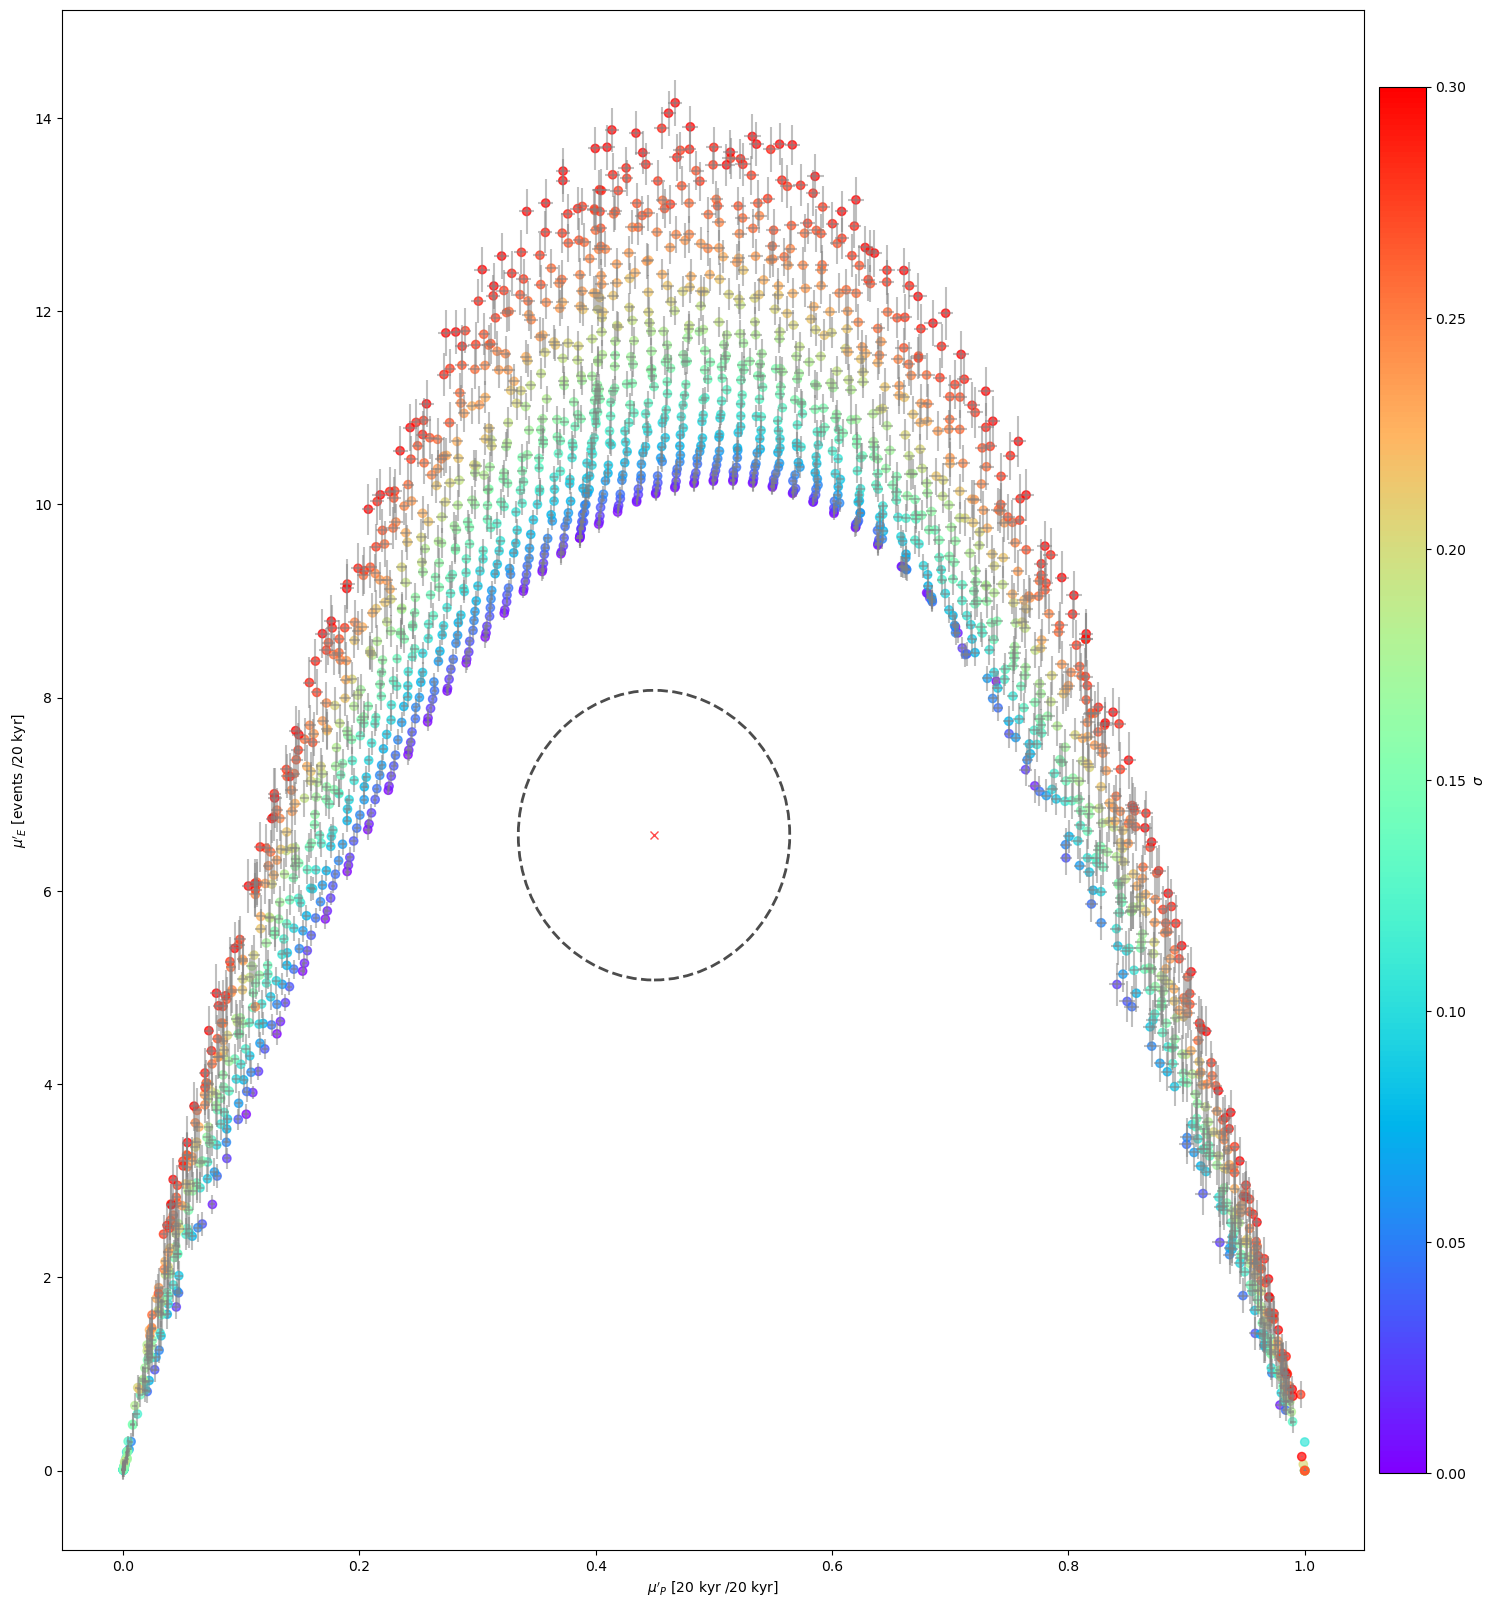

In [24]:

# increase the size of the figure
fig, ax = plt.subplots(1,1,figsize=(20,20))

# add oval with the data values from NGRIP
# center on E_data, P_data with width delta_E_data, delta_P_data

oval = matplotlib.patches.Ellipse(( P_data,E_data), delta_P_data,delta_E_data, edgecolor='k', facecolor='none', lw=2, linestyle = '--', alpha = 0.7)

# make it follow the boundaries of the bins
oval.set_clip_box(ax.bbox)

ax.add_patch(oval)

# add the center of the oval
ax.plot(P_data, E_data, marker = 'x', color = 'r', alpha = 0.7)

sigma_norm = plt.Normalize(vmin = np.min(sigma_for_plot_no_slope), vmax = np.max(sigma_for_plot_no_slope))
sm = plt.cm.ScalarMappable(cmap = 'rainbow', norm = sigma_norm)

ax.figure.colorbar(sm, ax = ax,
                    label = r'$\sigma$', shrink=0.9, pad=0.01,
        aspect=30)


# add the osmand_ data points with the color being based on sigma
ax.scatter(pair_E_P_no_slope[:,1], pair_E_P_no_slope[:,0], c = sigma_for_plot_no_slope, cmap = 'rainbow', alpha = 0.7)


norm = matplotlib.colors.LogNorm()
#pair_E_P_no_slopeplot = ax[3].hist2d(pair_E_P_no_slope[:,1], pair_E_P_no_slope[:,0], bins = 20, norm=norm, cmap = 'inferno',
#density = True)



for i in range(len(pair_E_P_no_slope[:,1])):
    ax.errorbar(pair_E_P_no_slope[i,1], pair_E_P_no_slope[i,0], xerr = delta_pair_E_P_no_slope[i,1], 
    yerr = delta_pair_E_P_no_slope[i,0], fmt = 'none', color = 'grey', alpha = 0.5, zorder = 1)

ax.set_ylabel(  r"$\mu'_E$" + ' [events /20 kyr]')
ax.set_xlabel(  r"$\mu'_P$" + ' [20 kyr /20 kyr]')




## Slope Grid

## Load the datasets

for the slope grid it is 3D. Here the grid search spans $\sigma \in [0,0.3], \gamma \in [0.6,3.0] \text{, and } \alpha \in [0,1]$ 
                      
                     /--------------------------------------------------/- alpha 1           
                    /                /                /                /|
                   /                /                /                / |
                  /                /                /                /  |
    sigma  0     |----------------|----------------|----------------|- alpha 0
                 |                |                |                |   |
                 |     file 1     |     file 2     |     file 3     |  /| 
                 |                |                |                | / |
    sigma  0.15  |----------------|----------------|----------------|/  |
                 |                |                |                |   /
                 |     file 4     |     file 5     |     file 6     |  /	
                 |                |                |                | /
    sigma  0.3   |----------------|----------------|----------------|/              
     gamma      0.6              1.4              2.2              3.0

And then all ran the total span of $\alpha$. All runs was with a resulotion of 
20 steps in $\gamma$, 20 in $\alpha$, and 5 in $\sigma$. As there were now many
more grip points thesse were only run with $N_{exp} = 10$.

In [25]:
slope_grid = []

for i in range(1, 7):
    slope_grid.append(xr.open_dataset(f'Data/Loh_polynode_alpha_10_5_20_20_file_{i}_alpha.nc'))

# combine the first three and the next three along the gamma axis

gamma_out_1 = xr.concat([slope_grid[0], slope_grid[1], slope_grid[2]], dim='gamma')
gamma_out_2 = xr.concat([slope_grid[3], slope_grid[4], slope_grid[5]], dim='gamma')
tot_slope = xr.concat([gamma_out_1, gamma_out_2], dim='sigma')



In [26]:
Number_exp = np.max(tot_slope.N_exp.values)


E_res = (tot_slope.mean_E/tot_slope.sigma_E**2).sum(dim='N_exp')/(1/tot_slope.sigma_E**2).sum(dim='N_exp')

delta_E_res = np.sqrt(1/(1/tot_slope.sigma_E**2).sum(dim='N_exp'))

# =========================================================================== #
# Contour plot of the proportion of interstadials P.

P_res = (tot_slope.mean_P/tot_slope.sigma_P**2).sum(dim='N_exp')/(1/tot_slope.sigma_P**2).sum(dim='N_exp').values

delta_P_res = np.sqrt(1/(1/tot_slope.sigma_P**2).sum(dim='N_exp'))



Ngrip_vec_mu = np.array([E_data, P_data])

Ngrip_vec_delta = np.array([delta_E_data, delta_P_data])

        

sim_vec_mu = np.array([E_res, P_res])

sim_vec_sigma = np.array([delta_E_res, delta_P_res])

# everywhere when E = 0 ergo no events, everything is nan
mask_e_zero = (sim_vec_mu[0] == 0)


numerator_ = np.zeros_like(sim_vec_mu[0])
denimator_ = np.zeros_like(sim_vec_mu[0])
sum_ = np.zeros_like(sim_vec_mu[0])

for i in range(2):
    #numerator_ += abs(sim_vec_mu[i] - Ngrip_vec_mu[i])
    #denimator_ += (sim_vec_sigma[i]**2 + Ngrip_vec_delta[i]**2)
    sum_ += (sim_vec_mu[i] - Ngrip_vec_mu[i])**2/np.sqrt((sim_vec_sigma[i]/np.sqrt(Number_exp))**2 + Ngrip_vec_delta[i]**2)

#z_test_total = numerator_/np.sqrt(denimator_)

z_test_total = sum_


z_test_total[mask_e_zero] = np.nan

z_min = np.nanmin(z_test_total)
 
print('min z test value: ', z_min)
# where is this value?

index_min = np.where(z_test_total == z_min)
print(index_min)

print('index of min z test value: \n', 
    ' sigma index: ', index_min[0][0], 'or ', tot_slope.sigma[index_min[0]].values, '\n',
    ' gamma index: ', index_min[1][0], 'or ', tot_slope.gamma[index_min[1][0]].values, '\n',
    ' alpha index: ', index_min[2][0], 'or ', tot_slope.alpha[index_min[2][0]].values)



min z test value:  0.004931322178155686
(array([6]), array([28]), array([10]))
index of min z test value: 
  sigma index:  6 or  [0.1875] 
  gamma index:  28 or  1.736842105263158 
  alpha index:  10 or  -0.5263157894736842


In [27]:
def distance_wheighted(x, y, x0, y0, dx, dy):
    return np.sqrt(((x-x0)/dx)**2 + ((y-y0)/dy)**2)


In [28]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl

pair_E_P_slope = np.array([E_res.values.flatten(), P_res.values.flatten()]).T
delta_pair_E_P_slope = np.array([delta_E_res.values.flatten(), delta_P_res.values.flatten()]).T

# the shape of the arrays are (sigma, gamma, alpha) make mehsgrid of the 
# sigma, gamma and alpha values so that the a index of pair_E_P_slope and delta_pair_E_P_slope
# corresponds to the sigma, gamma and alpha values. And can be back transformed
# to the sigma, gamma and alpha values
sigma_, gamma_, alpha_ = np.meshgrid(tot_slope.sigma.values, tot_slope.gamma.values, tot_slope.alpha.values)


# flatten the sigma_, gamma_ and alpha_ arrays
sigma_ = sigma_.flatten().T
gamma_ = gamma_.flatten().T
alpha_ = alpha_.flatten().T
# combine the pair_E_P_slope, delta_pair_E_P_slope, sigma_, gamma_ and alpha_ arrays to one array
# so that the sigma, gamma and alpha values are in the same row as the pair_E_P_slope and delta_pair_E_P_slope values

tot_pair_E_P_slope = np.vstack((pair_E_P_slope.T, delta_pair_E_P_slope.T, sigma_, gamma_, alpha_)).T


# find index of all data points that are within the ellipse using the distance_wheighted function
index = np.where(distance_wheighted(tot_pair_E_P_slope[:,1], tot_pair_E_P_slope[:,0], 
                P_data, E_data, delta_P_data/np.sqrt(Number_exp), 
                delta_E_data/np.sqrt(Number_exp)) < 1.2)

# scatter plot the data points that are within the ellipse with a green color
#plt.scatter(tot_pair_E_P_slope[index[0],1], tot_pair_E_P_slope[index[0],0], color = 'green', alpha = 0.5

print('number of data points within the ellipse: ', len(index[0]))

# print the sigma, alpha and gamma values of the data points that are within the ellipse
E_in_elipse = E_res.values.flatten()[index]
P_in_elipse = P_res.values.flatten()[index]
indexes_new = []
E_s = []

for i in range(len(E_in_elipse)):

    i_0 = np.where(E_res == E_in_elipse[i])
    indexes_new.append(np.array([tot_slope.sigma.values[i_0[0]], tot_slope.gamma.values[i_0[1]], tot_slope.alpha.values[i_0[2]]]))
    E_s.append(E_in_elipse[i])
indexes_new = np.array(indexes_new)

indexes_new = indexes_new.reshape(len(E_in_elipse), 3)

# remove the duplicates from the array and from the E_s array as well
# find the index of the duplicates in the indexes_new array
index_duplicates = np.unique(indexes_new, axis = 0, return_index = True)[1]

# remove the duplicates from the indexes_new array
indexes_new = indexes_new[index_duplicates]

# remove the duplicates from the E_s array
E_s = np.array(E_s)[index_duplicates]


# find the index of the E_s values in the E_in_elipse array
index_E_s = np.where(np.isin(E_in_elipse, E_s))
# convert the index_E_s array to indexes in tot_pair_E_P_slope array
index_no_double = index[0][index_E_s]


pair_E_P_slope = np.array([E_res.values.flatten(), P_res.values.flatten()]).T
delta_pair_E_P_slope = np.array([delta_E_res.values.flatten(), delta_P_res.values.flatten()]).T





# add a red cross for the data value
plt.scatter( P_data,E_data, marker = 'x', color = color_Ngrip, zorder = 10, s = 20)

oval = matplotlib.patches.Ellipse(( P_data,E_data), 
    2*delta_P_data/np.sqrt(Number_exp), 2*delta_E_data/np.sqrt(Number_exp), 
    edgecolor=color_Ngrip, facecolor='none', lw=2, linestyle = '--', zorder = 10)

plt.gca().add_patch(oval)



plt.xlabel(r"$\mu'_P$" + ' [20 kyr /20 kyr]')
plt.ylabel(r"$\mu'_E$" + ' [events /20 kyr]')
#plt.title('2d histogram of the grid search')


# print the sigma, alpha and gamma values of the data points that are within the ellipse

for i in range(tot_pair_E_P_slope.shape[0]):
    if i not in index[0]:
        plt.errorbar(tot_pair_E_P_slope[i,1], tot_pair_E_P_slope[i,0], 
                    xerr = tot_pair_E_P_slope[i,3], yerr = tot_pair_E_P_slope[i,2], 
                    fmt = 'none', zorder = 5, color = color_tot_points, alpha = 0.5)







# plot the data points that are within the ellipse and are also within the E_s array
# using a rainbow color scheme
# 
sigma_norm = plt.Normalize(vmin = np.min(indexes_new[:,0]), vmax = np.max(indexes_new[:,0]))

sm = plt.cm.ScalarMappable(cmap = 'rainbow', norm = sigma_norm)
sm._A = []
cbar = plt.colorbar(sm, ticks = indexes_new[:,0]) 



for i in range(len(index_no_double)):
    if indexes_new[i,0] == 0.1875:
    
        if indexes_new[i,1] == 1.736842105263158  :
            # make the outline of the error bar of the data point thicker
            plt.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2],
            fmt = '.', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)

            plt.scatter(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            color = sm.to_rgba(indexes_new[i,0]), zorder = 8, s = 20, edgecolor = 'k')
        
    else:
        plt.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0], 
        xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2], 
        fmt = 'none', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)


# ------------------------------ ZOOM IN --------------------------------------
# add a zoomed in version on the ellipse on the top right corner of the plot
ax2 = plt.axes([0.65, 0.45, 0.4, 0.4])


for i in range(tot_pair_E_P_slope.shape[0]):
    if i not in index[0]:
        ax2.errorbar(tot_pair_E_P_slope[i,1], tot_pair_E_P_slope[i,0], 
                    xerr = tot_pair_E_P_slope[i,3], yerr = tot_pair_E_P_slope[i,2], 
                    fmt = 'none', zorder = 5, color = color_tot_points, alpha = 0.5)


ax2.scatter( P_data,E_data, marker = 'x', color = color_Ngrip, zorder = 10, s = 20)
    
oval = matplotlib.patches.Ellipse(( P_data,E_data),
    2*delta_P_data/np.sqrt(Number_exp), 2*delta_E_data/np.sqrt(Number_exp),
    edgecolor=color_Ngrip, facecolor='none', lw=2, linestyle = '--', zorder = 10)

ax2.add_patch(oval)


for i in range(len(index_no_double)):
    if indexes_new[i,0] == 0.1875:
    
        if indexes_new[i,1] == 1.736842105263158  :
            # make the outline of the error bar of the data point thicker
            ax2.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2],
            fmt = '.', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)

            ax2.scatter(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            color = sm.to_rgba(indexes_new[i,0]), zorder = 8, s = 20, edgecolor = 'k')
    else:
        ax2.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
        xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2],
        fmt = 'none', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)
    
ax2.set_xlim(P_data-0.125, P_data+0.125)
ax2.set_ylim(E_data-1.125, E_data+1.125)

# remove the x and y ticks from the zoomed in plot
ax2.set_xticks([])
ax2.set_yticks([])

# add a colorbar to the plot
print(indexes_new)


cbar.ax.set_yticklabels(indexes_new[:,0].round(2))

# remove colorbar from big plot and add it to the zoomed in plot
cbar.remove()
cbar_zoom = ax2.figure.colorbar(sm, ax = ax2, ticks = indexes_new[:,0].round(2),
                    label = r'$\sigma$', orientation = 'horizontal',
                    fraction = 0.05, pad = 0.1)



# rotate the colorbar ticks
for tick in cbar_zoom.ax.xaxis.get_major_ticks():
    tick.label.set_rotation(-45)



print('number of data points within the ellipse: ', len(index_no_double))



number of data points within the ellipse:  21


NameError: name 'color_Ngrip' is not defined

/home/jonathanmelcher/Users/JOMel/wsl_conda/envs/Machine_learning/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/jonathanmelcher/Users/JOMel/wsl_conda/envs/Machine_learning/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/jonathanmelcher/Users/JOMel/wsl_conda/envs/Machine_learning/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/jonathanmelcher/Users/JOMel/wsl_conda/envs/Machine_learning/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/jonathanmelcher/Users/JOMel/wsl_conda/envs/Machine_learning/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
 

[[ 0.0375      1.35789474 -0.21052632]
 [ 0.075       1.44210526 -0.26315789]
 [ 0.1125      1.48421053 -0.31578947]
 [ 0.15        1.56842105 -0.36842105]
 [ 0.15        1.61052632 -0.42105263]
 [ 0.1875      1.69473684 -0.47368421]
 [ 0.1875      1.73684211 -0.52631579]
 [ 0.225       1.82105263 -0.57894737]
 [ 0.225       1.86315789 -0.63157895]
 [ 0.225       1.90526316 -0.63157895]
 [ 0.225       1.94736842 -0.68421053]
 [ 0.225       1.98947368 -0.73684211]
 [ 0.2625      2.11578947 -0.84210526]
 [ 0.2625      2.2        -0.89473684]
 [ 0.2625      2.24210526 -0.94736842]
 [ 0.2625      2.28421053 -1.        ]
 [ 0.2625      2.28421053 -0.94736842]
 [ 0.2625      2.32631579 -1.        ]]
number of data points within the ellipse:  18


/tmp/ipykernel_512959/1716070379.py:129: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(-45)


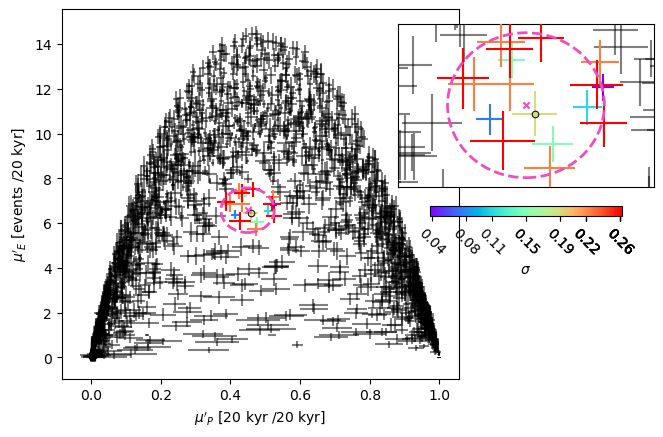

In [ ]:
## plotting



import seaborn as sns
color_palette = sns.color_palette("bright")

color_tot_points = 'k'
color_Ngrip = color_palette[6]
color_true_values = color_palette[4]




# add a red cross for the data value
plt.scatter( P_data,E_data, marker = 'x', color = color_Ngrip, zorder = 10, s = 20)

oval = matplotlib.patches.Ellipse(( P_data,E_data), 
    2*delta_P_data/np.sqrt(Number_exp), 2*delta_E_data/np.sqrt(Number_exp), 
    edgecolor=color_Ngrip, facecolor='none', lw=2, linestyle = '--', zorder = 10)

plt.gca().add_patch(oval)



plt.xlabel(r"$\mu'_P$" + ' [20 kyr /20 kyr]')
plt.ylabel(r"$\mu'_E$" + ' [events /20 kyr]')
#plt.title('2d histogram of the grid search')


# print the sigma, alpha and gamma values of the data points that are within the ellipse

for i in range(tot_pair_E_P_slope.shape[0]):
    if i not in index[0]:
        plt.errorbar(tot_pair_E_P_slope[i,1], tot_pair_E_P_slope[i,0], 
                    xerr = tot_pair_E_P_slope[i,3], yerr = tot_pair_E_P_slope[i,2], 
                    fmt = 'none', zorder = 5, color = color_tot_points, alpha = 0.5)


# plot the data points that are within the ellipse and are also within the E_s array
# using a rainbow color scheme
# 
sigma_norm = plt.Normalize(vmin = np.min(indexes_new[:,0]), vmax = np.max(indexes_new[:,0]))

sm = plt.cm.ScalarMappable(cmap = 'rainbow', norm = sigma_norm)
sm._A = []
cbar = plt.colorbar(sm, ticks = indexes_new[:,0]) 



for i in range(len(index_no_double)):
    if indexes_new[i,0] == 0.1875:
    
        if indexes_new[i,1] == 1.736842105263158  :
            # make the outline of the error bar of the data point thicker
            plt.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2],
            fmt = '.', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)

            plt.scatter(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            color = sm.to_rgba(indexes_new[i,0]), zorder = 8, s = 20, edgecolor = 'k')
        
    else:
        plt.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0], 
        xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2], 
        fmt = 'none', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)


# ------------------------------ ZOOM IN --------------------------------------
# add a zoomed in version on the ellipse on the top right corner of the plot
ax2 = plt.axes([0.65, 0.45, 0.4, 0.4])


for i in range(tot_pair_E_P_slope.shape[0]):
    if i not in index[0]:
        ax2.errorbar(tot_pair_E_P_slope[i,1], tot_pair_E_P_slope[i,0], 
                    xerr = tot_pair_E_P_slope[i,3], yerr = tot_pair_E_P_slope[i,2], 
                    fmt = 'none', zorder = 5, color = color_tot_points, alpha = 0.5)


ax2.scatter( P_data,E_data, marker = 'x', color = color_Ngrip, zorder = 10, s = 20)
    
oval = matplotlib.patches.Ellipse(( P_data,E_data),
    2*delta_P_data/np.sqrt(Number_exp), 2*delta_E_data/np.sqrt(Number_exp),
    edgecolor=color_Ngrip, facecolor='none', lw=2, linestyle = '--', zorder = 10)

ax2.add_patch(oval)


for i in range(len(index_no_double)):
    if indexes_new[i,0] == 0.1875:
    
        if indexes_new[i,1] == 1.736842105263158  :
            # make the outline of the error bar of the data point thicker
            ax2.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2],
            fmt = '.', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)

            ax2.scatter(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
            color = sm.to_rgba(indexes_new[i,0]), zorder = 8, s = 20, edgecolor = 'k')
    else:
        ax2.errorbar(tot_pair_E_P_slope[index_no_double[i],1], tot_pair_E_P_slope[index_no_double[i],0],
        xerr = tot_pair_E_P_slope[index_no_double[i],3], yerr = tot_pair_E_P_slope[index_no_double[i],2],
        fmt = 'none', color = sm.to_rgba(indexes_new[i,0]), zorder = 8)
    
ax2.set_xlim(P_data-0.125, P_data+0.125)
ax2.set_ylim(E_data-1.125, E_data+1.125)

# remove the x and y ticks from the zoomed in plot
ax2.set_xticks([])
ax2.set_yticks([])

# add a colorbar to the plot
print(indexes_new)


cbar.ax.set_yticklabels(indexes_new[:,0].round(2))

# remove colorbar from big plot and add it to the zoomed in plot
cbar.remove()
cbar_zoom = ax2.figure.colorbar(sm, ax = ax2, ticks = indexes_new[:,0].round(2),
                    label = r'$\sigma$', orientation = 'horizontal',
                    fraction = 0.05, pad = 0.1)



# rotate the colorbar ticks
for tick in cbar_zoom.ax.xaxis.get_major_ticks():
    tick.label.set_rotation(-45)



print('number of data points within the ellipse: ', len(index_no_double))

